In [7]:
!pip install ISLP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
import scipy.stats as stats
from ISLP.models import ModelSpec as MS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from ISLP.models import sklearn_sm
import statsmodels.api as sm
from sklearn.model_selection import cross_validate, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from pygam import (s as s_gam, LinearGAM)
from statsmodels.stats.stattools import durbin_watson
import scipy.stats as stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(55)
df = pd.read_csv('/kaggle/input/playground-series-s4e4/train.csv')
df = pd.get_dummies(df, columns=['Sex'], drop_first=True)
design = MS(df.columns.drop(['Rings', 'id'])).fit(df)
D = design.fit_transform(df)
D = D.drop('intercept', axis=1)
X = np.asarray(D)
Y = df['Rings']
cv_error = np.zeros(4)
M = sklearn_sm(sm.OLS)
cv = KFold(n_splits=10, shuffle=True, random_state=55)
for i, d in enumerate(range(1, 5)):
    poly = PolynomialFeatures(degree=d)
    X_poly = poly.fit_transform(X)
    M_CV = cross_validate(M, X_poly, Y, cv=cv)
    cv_error[i] = np.mean(M_CV['test_score'])
print("Cross-validation Errors for Degrees 1-4:", cv_error)

Cross-validation Errors for Degrees 1-4: [  3.98129849   3.65596203   3.60137043 168.9534651 ]


No considerable improvement between 3rd and 4th degree polynomials, so we choose the lower complexity polynomial

In [3]:
optimal_degree = 3
poly_optimal = PolynomialFeatures(degree=optimal_degree)
X_poly_optimal = poly_optimal.fit_transform(X)
final_model = LinearRegression()
final_model.fit(X_poly_optimal, Y)

print("Optimal Polynomial Degree:", optimal_degree)
print("Coefficients of the model with optimal degree:", final_model.coef_)
print("Intercept of the model with optimal degree:", final_model.intercept_)

Optimal Polynomial Degree: 3
Coefficients of the model with optimal degree: [ 4.05307525e-11 -1.03486812e+01  2.77815704e+01 -2.38261696e+01
  1.15335758e+01  9.34109160e+00 -2.19035101e+01  4.45994967e+01
  5.14760053e-01  2.87260272e-01 -1.08958034e+02  1.56005225e+02
  3.87790614e+02 -5.37588384e+01 -1.44998220e+02  1.52834524e+02
  2.87208027e+02  1.11089790e+01  9.99860808e-01 -1.27434967e+02
  1.06682832e+02 -2.26013966e+01 -1.21695763e+01  2.00881204e+02
 -2.63083521e+02 -1.60017110e+01 -2.27045927e+00  3.09098612e+00
 -4.66236171e+01  1.77812528e+02 -6.02607815e+02 -3.10409335e+02
 -1.81081943e+01 -9.53075817e+00  8.02983436e+00  3.80105332e+01
 -1.41421660e+02  1.46620228e+02  4.59743345e+00  2.93483292e+00
 -5.46789102e+01  1.44543100e+02 -1.22068123e+02 -2.36671894e+00
 -6.71746250e+00  1.53693692e+02 -1.59972138e+02  3.93211130e+00
  5.58953652e+00 -1.17313310e+02 -1.58116979e+01 -1.17932401e+00
  5.14760066e-01  1.57314162e-11  2.87260260e-01  2.94446199e+02
 -1.11035162e+

In [ ]:
y_pred = final_model.predict(X_poly_optimal)
y_pred = np.maximum(0, y_pred)
residuals = Y - y_pred

## Check Assumptions

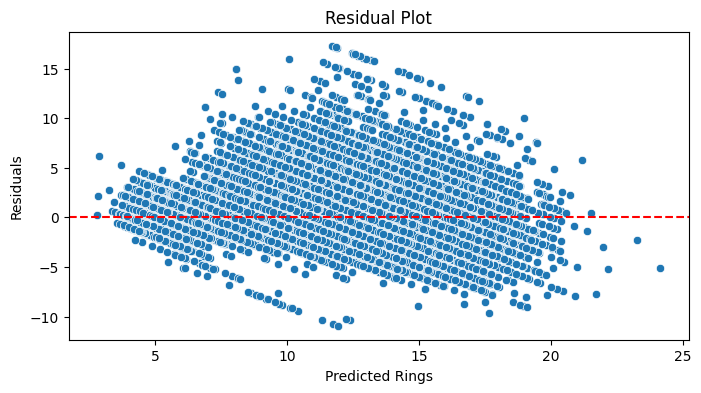

In [4]:
# Residual plot
plt.figure(figsize=(8, 4))
sns.scatterplot(x=y_pred, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Rings')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

Scatter pattern around the red line rejects linearity, and funnel shape rejects constant spread (homoscedasticity).

In [5]:
dw = durbin_watson(residuals)
print(f'Durbin-Watson statistic: {dw:.2f}')

Durbin-Watson statistic: 2.00


DW ≈ 2 → no autocorrelation.

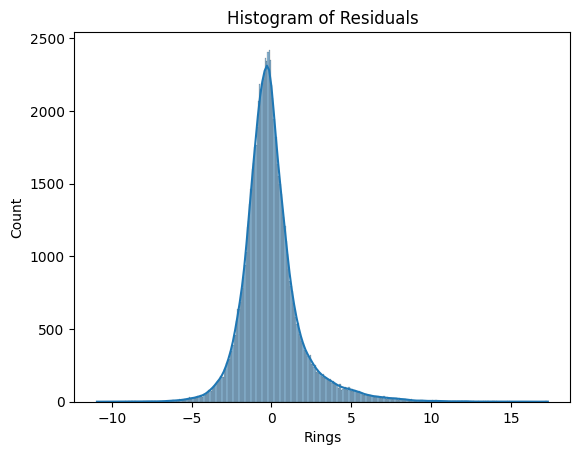

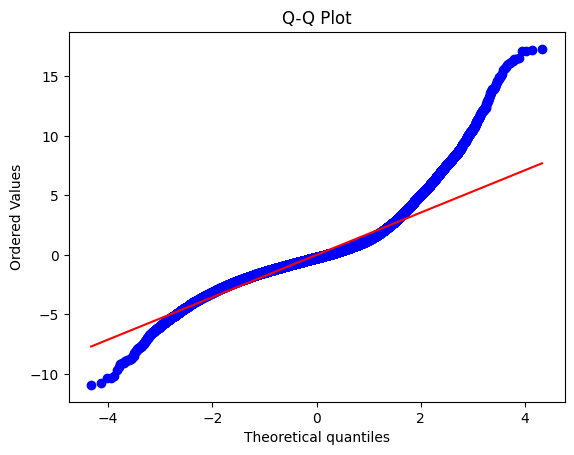

In [9]:
sns.histplot(residuals, kde=True)
plt.title("Histogram of Residuals")
plt.show()

# Q-Q plot
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

Not all points fall on 45 degree red line, the normality assumption does not hold up.

In [10]:
# Check VIFs
vif_data = pd.DataFrame()
vif_data["feature"] = D.columns
vif_data["VIF"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
print(vif_data)

          feature         VIF
0          Length  934.989831
1        Diameter  965.624164
2          Height  103.614949
3    Whole weight  272.066683
4  Whole weight.1   80.232745
5  Whole weight.2   76.546052
6    Shell weight   72.358331
7           Sex_I    2.929687
8           Sex_M    2.122060


VIF > 5 → moderate multicollinearity.  
VIF > 10 → severe multicollinearity.

In [11]:
# --- Load test data ---
test_df = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")
test_ids = test_df["id"]
test_df = pd.get_dummies(test_df, columns=['Sex'], drop_first=True)
design2 = MS(test_df.columns.drop('id')).fit(test_df)
D2 = design2.fit_transform(test_df)
D2 = D2.drop('intercept', axis=1)
X_test = np.asarray(D2)
X_test_poly_optimal = poly_optimal.fit_transform(X_test)
# --- Predict using Model ---
preds = final_model.predict(X_test_poly_optimal)
preds = np.maximum(0, preds)

# --- Save submission files ---
submission = pd.DataFrame({'id': test_ids, 'Rings': preds})
submission.to_csv("submission_model.csv", index=False)
print("Submissions saved: submission_model.csv")

Submissions saved: submission_model.csv
